<a href="https://colab.research.google.com/github/hourglasshoro/research-notebook/blob/main/make_interjection_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

In [8]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1b37tFCEfeX4jN5hdiV7aLGgMv7MQOpAL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1b37tFCEfeX4jN5hdiV7aLGgMv7MQOpAL" -O /content/dataset.zip && rm -rf /tmp/cookies.txt
!unzip -q /content/dataset.zip -d /content

--2021-04-01 03:55:08--  https://docs.google.com/uc?export=download&confirm=UEjQ&id=1b37tFCEfeX4jN5hdiV7aLGgMv7MQOpAL
Resolving docs.google.com (docs.google.com)... 142.250.73.206, 2607:f8b0:4004:806::200e
Connecting to docs.google.com (docs.google.com)|142.250.73.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-bs-docs.googleusercontent.com/docs/securesc/toecukphd8gv8n2ci7pu5irh87d5sp6r/cplair4k986j8vk15rn9ekaseldcdbio/1617249300000/03816308716299652124/08101960410271729372Z/1b37tFCEfeX4jN5hdiV7aLGgMv7MQOpAL?e=download [following]
--2021-04-01 03:55:08--  https://doc-0c-bs-docs.googleusercontent.com/docs/securesc/toecukphd8gv8n2ci7pu5irh87d5sp6r/cplair4k986j8vk15rn9ekaseldcdbio/1617249300000/03816308716299652124/08101960410271729372Z/1b37tFCEfeX4jN5hdiV7aLGgMv7MQOpAL?e=download
Resolving doc-0c-bs-docs.googleusercontent.com (doc-0c-bs-docs.googleusercontent.com)... 172.217.7.225, 2607:f8b0:4004:802::2001
Connecting to doc-0c

In [2]:
!apt install aptitude swig > /dev/null
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y > /dev/null
!pip install mecab-python3==0.996.3 > /dev/null
!pip install pykakasi > /dev/null
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a > /dev/null



Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 54 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  3091k      0  0:00:03  0:00:03 --:--:-- 4095k
./../../libexec/iconv_euc_to_utf8.sh ./Noun.demonst.csv 
./../../libexec/iconv_euc_to_utf8.sh ./Noun.adjv.csv 
./../../libexec/iconv_euc_to_utf8.sh ./Others.csv 
./../../libexec/iconv_euc_to_utf8.sh ./Noun.place.csv 
./../../libexec/iconv_euc_to_utf8.sh ./Noun.others.csv 
./../../libexec/iconv_euc_to_utf8.sh ./Noun.csv 
./../../libexec/iconv_euc_to_utf8.sh ./Adverb.csv 
./../../libexec/iconv_euc_to_utf8.

In [3]:
!pip install nptyping > /dev/null

In [4]:
!mkdir /content/dataset
!mkdir /content/dataset/wav

## Generate
Interjection index : https://github.com/hourglasshoro/research-notebook/blob/main/interjection_index.ipynb


In [5]:
import numpy as np
import librosa
import random
from nptyping import NDArray, Float32, Int32
import csv
from scipy.io.wavfile import write
import subprocess
import MeCab
import os
import json
import IPython.display

In [50]:
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

def interjection(point: np.float32, wav: NDArray[Float32], silence: NDArray[Float32], sr: np.float32) -> (NDArray[Float32], np.int32, np.int32):
  """
  言い淀みの挿入ポイントに対して1〜３個の言い淀みを合成して挿入する

  Parameters
  ----------
  point : np.float32
    言い淀みの挿入ポイント（秒数）
  wav : NDArray[Float32]
    合成する元のデータ
  silence : NDArray[Float32]
    合成する環境音データ
  sr : np.float32
    サンプルレート

  Returns
  -------
  output : NDArray[Float32]
    合成後の生成物
  start : np.int32
    言い淀みの開始フレーム
  end : np.int32
    言い淀みの終了フレーム
  """

  injection_point = int(sr*point)

  # ゼロクロスポイント
  frame = 4096
  sig = wav[injection_point-frame:injection_point+frame]
  indices = find((sig[1:] >= 0) & (sig[:-1] < 0))
  idx = np.abs(np.asarray(indices - frame) - 0).argmin()
  zero_cross_diff = indices[idx] - frame

  injection_point += zero_cross_diff

  # 前半部分
  output = wav[:injection_point]

  # フィラー
  try_count = random.randint(1,3)
  inter_wav = []

  for interjection in random.sample(interjection_dirs, try_count):
    # 言い淀みは100個生成しているのでランダムに選ぶ（0〜99）
    f = interjection + str(random.randint(0,99)) + '.wav'
    f = os.path.join(base_dir,'interjection',interjection,f)
    iwav, sr = librosa.load(f, sr=SAMPLE_RATE)
    inter_wav = np.append(inter_wav, iwav)

    # 無音
    inter_wav = np.append(inter_wav,silence[:int(sr*random.uniform(0.01, 0.3))])

  output = np.append(output,inter_wav)

  start = injection_point
  end = injection_point + len(inter_wav)

  # 後半
  output = np.append(output,wav[injection_point:])

  # len_windowの長さにトリミングする
  margin = int(sr*5)
  output = np.append(np.zeros(margin),output)
  output = np.append(output,np.zeros(margin))
  start = start + margin
  end = end + margin
  filler = end - start
  len_window = int(sr*5)
  reminding = len_window - filler
  first_span_len = random.randint(0, reminding)
  last_span_len = reminding - first_span_len
  trimmed_start = start - first_span_len
  trimmed_end = end + last_span_len
  start = first_span_len
  end = start + filler
  output = output[trimmed_start:trimmed_end]

  return output, start, end

def get_injection_point(json_file:str)->NDArray[Float32]:
  """
  あらかじめタイムスタンプを含む解析結果と形態素解析に基づく挿入ポイントのマッピングをする

  Parameters
  ----------
  json_file : srt
    解析結果を含むJSONファイルの場所

  Returns
  -------
  timestamps : NDArray[Float32]
    挿入ポイントのタイムスタンプ（秒数）
  """

  timestamps = []
  with open(json_file, 'r', encoding='UTF-8') as fj:
    content = fj.read()
    content = json.loads(content)
    transcript = content['results'][0]['alternatives'][0]['transcript']
    term_idx = get_injection_index(transcript)
    for idx in term_idx:
      timestamp = content['results'][0]['alternatives'][0]['timestamps'][idx][2]
      timestamps = np.append(timestamps,timestamp)
  return timestamps

def get_injection_index(transcript:str)->NDArray[Int32]:
  """
  あらかじめタイムスタンプを含む解析結果と形態素解析に基づく挿入ポイントのマッピングをする

  Parameters
  ----------
  transcript : srt
    外部解析結果に含まれるトランスクリプト

  Returns
  -------
  term_idx : NDArray[Float32]
    形態素解析に基づく挿入ポイントのインデックス（解析結果の単語の配列に合わせてある）
  """

  node = m.parseToNode(transcript).next
  transcript_splited = transcript.split(' ')

  term_idx = []
  term_buf = ''

  index = 0
  while node:

      # 単語
      term = node.surface
      term_buf = term_buf + term

      # 品詞
      pos = node.feature.split(',')[0]

      # transcriptより細かい粒度で分割された時はバッファにためる
      if term_buf != transcript_splited[index]:
        node = node.next
        continue

      # もし品詞が条件と一致してたら
      if pos == '助詞':
        # 助詞が連続している場合は最後のものを使用する
          if len(term_idx) !=0 and term_idx[-1] == index-1:
            term_idx = term_idx[:len(term_idx)-1]
          term_idx.append(index)

      term_buf = ''
      node = node.next
      index = index+1
    
  return term_idx

In [7]:
cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
m = MeCab.Tagger("-d {0}".format(path))

In [ ]:
SAMPLE_RATE = 24000
random.seed(0)

dirs = ['basic5000','precedent130','repeat500','loanword128','travel1000','onomatopee300','utparaphrase512']
base_dir = '/content/jsut_ver1.1'
output_dir = '/content/dataset'
interjection_dirs = ['a','ano','e','eto','ma']
output_path = os.path.join(output_dir, 'interjection_data.csv')
index = 0
silence_path = os.path.join(base_dir,'interjection','silence.wav')
silence, sr = librosa.load(silence_path, sr=SAMPLE_RATE)

with open(output_path, 'w', encoding='UTF-8') as fcsv:
  for dir in dirs:
    file_path = os.path.join(base_dir,dir,'correct_stt.txt')
    with open(file_path, 'r', encoding='UTF-8') as fc:
      datalist = fc.readlines()

      fieldnames = ['id', 'wav', 'start', 'end']
      writer = csv.DictWriter(fcsv, fieldnames=fieldnames)
      writer.writeheader()

      for data in datalist:
        # 改行を削除
        data = data.rstrip(os.linesep)
        file_name = data + '.wav'
        file_name = os.path.join(base_dir,dir,'wav',file_name)
        wav, sr = librosa.load(file_name, sr=SAMPLE_RATE)

        file_name = data + '.json'
        file_name = os.path.join(base_dir,dir,'json',file_name)
        injection_points = get_injection_point(file_name)

        for i, point in enumerate(injection_points):
          wav_file_name = data + '_' + str(i) +'.wav'
          output, start, end = interjection(point, wav, silence, sr)
          writer.writerow({'id': index, 'wav': wav_file_name, 'start': start, 'end': end})

          wav_file_name = os.path.join(output_dir,'wav',wav_file_name)
          write(wav_file_name, sr, output)

          index = index + 1

Test generate

In [55]:
SAMPLE_RATE = 24000
random.seed(1)

dirs = ['precedent130']
base_dir = '/content/jsut_ver1.1'
output_dir = '/content/dataset'
interjection_dirs = ['a','ano','e','eto','ma']
output_path = os.path.join(output_dir, 'interjection_data.csv')
index = 0
silence_path = os.path.join(base_dir,'interjection','silence.wav')
silence, sr = librosa.load(silence_path, sr=SAMPLE_RATE)

dir = 'precedent130'
data = "PRECEDENT130_001"
file_name = data + '.wav'
file_name = os.path.join(base_dir,dir,'wav',file_name)
wav, sr = librosa.load(file_name, sr=SAMPLE_RATE)

file_name = data + '.json'
file_name = os.path.join(base_dir,dir,'json',file_name)
injection_points = get_injection_point(file_name)
point = injection_points[0]
output, start, end = interjection(point, wav, silence, sr)

In [56]:
IPython.display.Audio(data=output, rate=sr)

In [48]:
import librosa.display

In [46]:
frame = int(0.025*25000)
overlap = int(0.010*25000)

def show_stft(n_fft,hop_length,wav):
    S = np.abs(librosa.stft(wav ,n_fft,hop_length))**2
    melspec = librosa.feature.melspectrogram(S=S)
    log_melspec = librosa.power_to_db(melspec)
    librosa.display.specshow(log_melspec, sr=sr, x_axis='time', y_axis='mel')

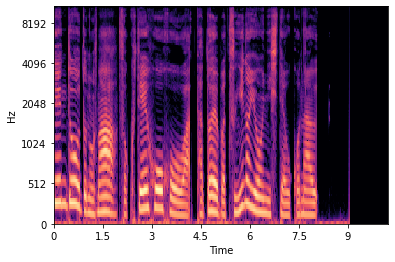

In [57]:
show_stft(frame,overlap, output)

### Confirming

In [ ]:
!ls /content/dataset/wav -1 | wc -l

15913


In [ ]:
file_name = '/content/dataset/wav/BASIC5000_0001_0.wav'
test, sr = librosa.load(file_name, sr=24000)
IPython.display.Audio(data=test, rate=sr)

In [ ]:
file_name = '/content/dataset/wav/UT-PARAPHRASE-sent313-phrase2_7.wav'
test, sr = librosa.load(file_name, sr=24000)
IPython.display.Audio(data=test, rate=sr)

### Save

In [ ]:
!zip -r interjection_data.zip /content/dataset > /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/interjection_data.zip /content/drive/MyDrive/dataset/